c:\users\admin\anaconda3\envs\myenv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\admin\anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\admin\anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


Etalonnage Fort des caméras


a) Réaliser avec python l’étalonnage des deux caméras. Vous utiliserez la méthode vue en cours pour calculer les matrices de projections des deux caméras.


Matrices de projection de la caméra droite:
[[-2.98847757e+03  6.01213184e+02 -6.03761084e+01  1.40515470e+05]
 [ 6.74292691e+01 -3.19511293e+03 -7.77595154e+02  7.41789482e+04]
 [ 1.90153079e-01  7.93742108e-01 -5.77767490e-01  1.51929322e+02]]


Matrices de projection de la caméra gauche:
[[-3.41030173e+03 -3.45647474e+02 -1.55451250e+02  1.63013178e+05]
 [ 2.16089571e+02 -3.22813757e+03 -8.19288224e+02  9.39678029e+04]
 [-2.58293939e-01  6.20145872e-02 -9.64073873e-01  1.59337996e+02]]
---------------------


b) Quelle est la hauteur de chaque caméra. Evaluer la précision de l’étalonnage.


Hauteur de la caméra droite:
151.92932238447713


Hauteur de la caméra gauche:
159.33799572715998


Précision de l’étalonnage de la caméra droite:
26.767032665451055


Précision de l’étalonnage de la caméra gauch

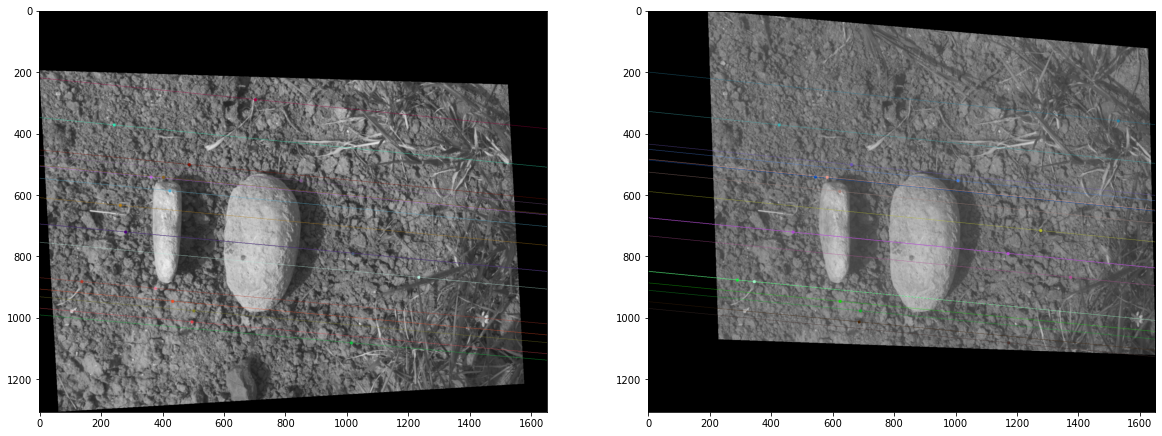

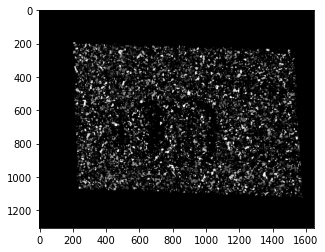

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

class tp_3d:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        
    def get_data(self, path):
        with open(path) as f:
            lines = [line.strip() for line in f]

        lines = [(line.split(' ')) for line in lines]   
        coord3d=[]
        coord2d=[]
        for i in range(len(lines)):
            l1=[]
            l2=[]
            for j in range(len(lines[i])):
                if(j<=2):
                    l1.append(float(lines[i][j]))
                else:
                    l2.append(float(lines[i][j]))
            coord3d.append(l1)
            coord2d.append(l2)

        return np.array(coord3d), np.array(coord2d)


    def matrice_projection(self, coord3d, coord2d):
        n = coord2d.shape[0]
        u = coord2d[:,0]
        v = coord2d[:,1]

        X = coord3d[:,0]
        Y = coord3d[:,1]
        Z = coord3d[:,2]

        K=[]
        C=[]
        for i in range(n):
            r1=[X[i], Y[i], Z[i], 1, 0, 0, 0, 0, 
                -u[i]*X[i], -u[i]*Y[i], -u[i]*Z[i]]

            r2=[0, 0, 0, 0, X[i], Y[i], Z[i], 1, -v[i]*X[i], 
                -v[i]*Y[i], -v[i]*Z[i]]

            K.append(r1)
            K.append(r2)

            C.append(u[i])
            C.append(v[i])

        K = np.array(K)
        C = np.array(C)

        Q = np.dot(np.dot(np.linalg.inv(np.dot(K.T, K)), K.T), C)   # Q=(((K^t).K)^-1).(K^t).C

        q31 = Q[len(Q)-3]
        q32 = Q[len(Q)-2]
        q33 = Q[len(Q)-1]
        m34 = np.sqrt(1/(q31**2 + q32**2 + q33**2))

        M = [[Q[0]*m34, Q[1]*m34, Q[2]*m34, Q[3]*m34],
             [Q[4]*m34, Q[5]*m34, Q[6]*m34, Q[7]*m34],
             [Q[8]*m34, Q[9]*m34, Q[10]*m34, m34]]
        M=np.array(M)

        return M

    
    def calcul_matrice_essentielle_fondamentale(self, coord2d_droite, coord2d_gauche):
        E, _ = cv2.findEssentialMat(coord2d_gauche,coord2d_droite)
        F, _ = cv2.findFundamentalMat(coord2d_droite, coord2d_gauche)
        return E, F

    
    def err(self, M, coord3d, uv):
        uv_proj = np.dot( M, np.concatenate( (coord3d.T, np.ones((1, coord3d.shape[0]))) ) ) 
        uv_proj = uv_proj / uv_proj[2, :] 
        
        err = np.sqrt( np.mean(np.sum( (uv_proj[0:2, :].T - uv)**2, 1)) ) 

        return err

    def calc_intrin_extrin(self, M):
        k = np.sqrt(dot(M[2], M[2].T))
        Tz = (1/k) * M[2, 3]
        u0 = (1/(k**2)) * np.dot(M[0], M[2].T)
        v0 = (1/(k**2)) * np.dot(M[1], M[2].T)
        alpha_u = np.sqrt((1/(k**2)) * np.dot(M[0], M[0].T) - u0**2)
        alpha_v = np.sqrt((1/(k**2)) * np.dot(M[1], M[1].T) - v0**2)
        Tx = (1/(k * alpha_u)) * (M[0, 3] - 
                                  ((np.dot(M[0], M[2].T))/(k**2))
                                  * M[2, 3])
        Ty = (1/(k * alpha_v)) * (M[1, 3] - 
                                  ((np.dot(M[1], M[2].T))/(k**2))
                                  * M[2, 3])
        r1 = (M[0] - u0 * M[2])/(k * alpha_u)
        r2 = (M[1] - v0 * M[2])/(k * alpha_v)
        r3 = (1/k) * M[2]

        return k, Tz, u0, v0, alpha_u, alpha_v, Tx, Ty, r1, r2, r3
    
    def calc_center(self, M):
        k = np.sqrt(np.dot(M[2], M[2].T))
        Tz = (1/k) * M[2, 3]
        u0 = (1/(k**2)) * np.dot(M[0], M[2].T)
        v0 = (1/(k**2)) * np.dot(M[1], M[2].T)
        alpha_u = np.sqrt((1/(k**2)) * np.dot(M[0], M[0].T) - u0**2)
        alpha_v = np.sqrt((1/(k**2)) * np.dot(M[1], M[1].T) - v0**2)
        Tx = (1/(k * alpha_u)) * (M[0, 3] - 
                                  ((np.dot(M[0], M[2].T))/(k**2))
                                  * M[2, 3])
        Ty = (1/(k * alpha_v)) * (M[1, 3] - 
                                  ((np.dot(M[1], M[2].T))/(k**2))
                                  * M[2, 3])
        r1 = (M[0] - u0 * M[2])/(k * alpha_u)
        r2 = (M[1] - v0 * M[2])/(k * alpha_v)
        r3 = (1/k) * M[2]

        return [Tx, Ty, Tz]
    
    def exercice1(self):

        coord3d_droite, coord2d_droite = self.get_data(self.folder_path+"/droite.txt")
        M_droite = self.matrice_projection(coord3d_droite, coord2d_droite);
        err_droite = self.err(M_droite, coord3d_droite, coord2d_droite)
        
        coord3d_gauche, coord2d_gauche = self.get_data(self.folder_path+"/gauche.txt")
        M_gauche = self.matrice_projection(coord3d_gauche, coord2d_gauche)
        err_gauche = self.err(M_gauche, coord3d_gauche, coord2d_gauche)
        
        E, F = self.calcul_matrice_essentielle_fondamentale(coord2d_droite, coord2d_gauche)
        
        camera_center_droite = self.calc_center(M_droite)
        camera_center_gauche = self.calc_center(M_gauche)
        
        B = np.sqrt((camera_center_droite[0]-camera_center_gauche[0])**2 +
                      (camera_center_droite[1]-camera_center_gauche[1])**2 +
                      (camera_center_droite[2]-camera_center_gauche[2])**2)
        
        H_moy = (M_droite[2,3]+M_gauche[2,3])/2
        
        alpha_u = 3220
        alpha_v = 3220
        Rx = H_moy/(alpha_u)
        Ry = H_moy/(alpha_v)
        Rz = (H_moy**2)/(alpha_u*B)
        
        print('Etalonnage Fort des caméras')
        print('\n')
        print("a) Réaliser avec python l’étalonnage des deux caméras. Vous utiliserez la méthode vue en cours pour calculer les matrices de projections des deux caméras.")
        print('\n')   
        print('Matrices de projection de la caméra droite:')
        print(M_droite)
        print('\n')
        print('Matrices de projection de la caméra gauche:')
        print(M_gauche)
        print('---------------------')
        print('\n')
        
        print('b) Quelle est la hauteur de chaque caméra. Evaluer la précision de l’étalonnage.')
        print('\n')
        print('Hauteur de la caméra droite:')
        print(M_droite[2,3])
        print('\n')
        print('Hauteur de la caméra gauche:')
        print(M_gauche[2,3])
        print('\n')
        print('Précision de l’étalonnage de la caméra droite:')
        print(err_droite)
        print('\n')
        print('Précision de l’étalonnage de la caméra gauche:')
        print(err_gauche)
        print('---------------------')
        print('\n')
        
        print("c) Calculer la matrice essentielle et la matrice fondamentale.")
        print('\n')
        print('Matrice essentielle:')
        print(E)
        print('\n')
        print('Matrice fondamentale:')
        print(F)      
        print('---------------------')
        print('\n')
        
        print('d) Calculer les coordonnées des centres optiques. En déduire la distance qui sépare les deux caméras.')
        print("Camera center droite:")
        print(camera_center_droite)
        print('\n')
        print("Camera center gauche:")
        print(camera_center_gauche)
        print('\n')
        print("distance qui sépare les deux caméras:")
        print(B)
        print('---------------------')
        print('\n')
        
        print("e) En utilisant la hauteur moyenne des deux caméras calculer la résolution Rz qu’on peut avoir pour le modèle 3D (αu=αv=3220) ainsi que les résolutions Rx et Ry.")
        print("\n")
        print('Rx = '+str(Rx))
        print('\n')
        print('Ry = '+str(Ry))
        print('\n')
        print('Rz = '+str(Rz))
        print('---------------------')
        print('\n')
        
        
    def get_data2(self, path):
        
        with open(path) as f:
            lines = [line.strip() for line in f]

        lines = [(line.split(' ')) for line in lines]   
        u=[]
        v=[]
        for i in range(len(lines)):
            l1=[]
            l2=[]
            for j in range(len(lines[i])):
                if(j<2):
                    l1.append(float(lines[i][j]))
                elif(2<=j<=3):
                    l2.append(float(lines[i][j]))
            
            u.append(l1)
            v.append(l2)

        return np.array(u), np.array(v)
    
        
    def calcul_matrice_fondamentale(self, u, v):
        n = u.shape[1]

        A = np.zeros((n,9))
        for i in range(n):
            A[i] = [u[0,i]*v[0,i], u[0,i]*v[1,i], u[0,i]*v[2,i],
                    u[1,i]*v[0,i], u[1,i]*v[1,i], u[1,i]*v[2,i],
                    u[2,i]*v[0,i], u[2,i]*v[1,i], u[2,i]*v[2,i] ]

        U,S,V = np.linalg.svd(A)
        F = V[-1].reshape(3,3)

        U,S,V = np.linalg.svd(F)
        S[2] = 0
        F = np.dot(U,np.dot(np.diag(S),V))

        return F/F[2,2]


    def epipole(self, F):
        
        U,S,V = np.linalg.svd(F)
        e = V[-1]
        return e/e[2]

    
    def drawlines(self,img1,img2,lines,pts1,pts2):
        
        r,c = img1.shape
        img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
        img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
        for r,pt1,pt2 in zip(lines,pts1,pts2):
            color = tuple(np.random.randint(0,255,3).tolist())
            x0,y0 = map(int, [0, -r[2]/r[1] ])
            x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
            img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
            img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
            img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
        return img1,img2


    def get_matches(self, image1, image2):

        detect = cv2.BRISK_create()

        keypoints1, descriptors1 = detect.detectAndCompute(image1, None)
        keypoints2, descriptors2 = detect.detectAndCompute(image2, None)

        match = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        match_result = match.match(descriptors1, descriptors2)

        return match_result, keypoints1, descriptors1, keypoints2, descriptors2
    
    
    def plot_line(self, img1, img2, pts1, pts2, F):
        lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
        lines1 = lines1.reshape(-1,3)
        img5,img6 = self.drawlines(img1,img2,lines1,pts1,pts2)

        lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
        lines2 = lines2.reshape(-1,3)
        img3,img4 = self.drawlines(img2,img1,lines2,pts2,pts1)
        
        plt.figure(figsize=(20,10))
        plt.subplot(121),plt.imshow(img5)
        plt.subplot(122),plt.imshow(img3)
        plt.show()


    def new_fondamentale(self, image1, image2):

        match_result, keypoints1, _, keypoints2, _ = self.get_matches(image1, image2)
        points1 = []
        points2 = []
        
        for match in match_result:
            points1.append(keypoints1[match.queryIdx].pt)
            points2.append(keypoints2[match.trainIdx].pt)

        points1 = np.array(points1, dtype=np.int32)
        points2 = np.array(points2, dtype=np.int32)

        fundamental_mat, mask = cv2.findFundamentalMat(points1, points2, cv2.FM_8POINT + cv2.FM_RANSAC, 10**-2, 10**-5)

        points1 = points1[mask.ravel()==1]
        points2 = points2[mask.ravel()==1]

        return fundamental_mat, points1, points2


    def exercice2(self):
        u, v = self.get_data2(self.folder_path+'/matches')

        F = self.calcul_matrice_fondamentale(u, v)
        
        droiter = cv2.imread(self.folder_path+'/droiter.png',0)
        gaucher = cv2.imread(self.folder_path+'/gaucher.png',0)
        
        e_droite = self.epipole(F)
        e_gauche = self.epipole(F.T)


        fundamental_mat, img_points1, img_points2 = self.new_fondamentale(droiter, gaucher)
        
        print('Etalonnage Faible des caméras')
        print('\n')
        print('a) Calculer la matrice fondamentale par une méthode linéaire.')
        print('La matrice fondamentale:')
        print(F)
        print('---------------------')
        print('\n')
        
        print('b) Déterminer et tracer l’équation de la droite épipolaire dans l’image droite du pixel (657,729) de l’image gauche. Ecrire une fonction qui calcule cette droite pour n’importe quel pixel de l’image gauche.')
        print('Epipole droite:')
        print(e_droite)
        print('\n')
        print('Epipole gauche:')
        print(e_gauche)
        print('---------------------')
        print('\n')
        
        print('c) Calculer les coordonnées des épipoles.')
        print('img_points1:')
        print(img_points1)
        print('\n')
        print('img_points2:')
        print(img_points2)
        print('---------------------')
        print('\n')
        
        print('d)Réaliser la détection et le matching de points d’intérêt sur les deux images pour calculer la matrice fondamentale')
        print('La matrice fondamentale:')
        print(fundamental_mat)
        print('---------------------')
        print('\n')
 
        self.plot_line(droiter, gaucher, img_points1, img_points2, fundamental_mat)
    
    def exercice3(self):
        droiter = cv2.imread(self.folder_path+'/droiter.png',0)
        gaucher = cv2.imread(self.folder_path+'/gaucher.png',0)

        stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
        disparity = stereo.compute(droiter,gaucher)
        plt.imshow(disparity,'gray')
        plt.show()

if __name__ == "__main__":
    tp=tp_3d(folder_path="./dataset_tp_setero")
    tp.exercice1()
    tp.exercice2()
    tp.exercice3()